# **A multi-class classification network for classifying the generated text**

We test the quality of the text generated with our text generation model through a multi-classification model. 

# Hyper-parameters

In [0]:
vocab_size = 5000
embedding_dim = 50
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

num_epochs = 5

# Import the libraries

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
 raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Embedding, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Bidirectional, MaxPooling1D, GlobalMaxPool1D, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string

from sklearn.manifold import TSNE
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Version check

In [0]:
print('Tensorflow version:', tf.__version__)
print("Is eagerly mode activated:", tf.executing_eagerly())

Tensorflow version: 2.1.0
Is eagerly mode activated: True


# Read the dataset

In [0]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1EChD2ifPR0HCFRsEeTxOjxU4V6mMtflf'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1EChD2ifPR0HCFRsEeTxOjxU4V6mMtflf


In [0]:
downloaded = drive.CreateFile({'id':id})

In [0]:
%%time
downloaded.GetContentFile('hansard-1979-2018-v261.csv')  
#hansard = pd.read_csv('hansard-1979-2018-v261.csv')# Dataset is now stored in a Pandas Dataframe

CPU times: user 3.36 s, sys: 11.5 s, total: 14.8 s
Wall time: 1min 23s


In [0]:
columns = ['speech', 'year', 'party_group']
traintypes = {
'speech':'object',
'year':'int32',
'party_group':'object'}

In [0]:
%%time
hansard = pd.read_csv('hansard-1979-2018-v261.csv', usecols=columns, dtype=traintypes)# Dataset is now stored in a Pandas Dataframe

CPU times: user 21.7 s, sys: 911 ms, total: 22.6 s
Wall time: 22.7 s


In [0]:
hansard.shape

(2286324, 3)

In [0]:
hansard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286324 entries, 0 to 2286323
Data columns (total 3 columns):
speech         object
year           int32
party_group    object
dtypes: int32(1), object(2)
memory usage: 43.6+ MB


# Pre-process the data

#### Keep speeches after 1997

In [0]:
#Drop rows with year < 1995
hansard.drop(hansard.loc[hansard['year']<1996].index, inplace=True)
#hansard.drop(hansard['year']<1995, axis=0, inplace=True)

In [0]:
hansard.shape

(1327413, 3)

In [0]:
hansard.drop('year', axis=1, inplace=True)

In [0]:
hansard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327413 entries, 958911 to 2286323
Data columns (total 2 columns):
speech         1327410 non-null object
party_group    1251907 non-null object
dtypes: object(2)
memory usage: 30.4+ MB


#### Check to see if we have **nan** values also rows with empty speech column

In [0]:
hansard.isnull().sum()

speech             3
party_group    75506
dtype: int64

In [0]:
# Drop rows that contain NaN values
hansard.dropna(subset=['speech', 'party_group'], inplace=True)

In [0]:
hansard.shape

(1251907, 2)

In [0]:
hansard.reset_index(drop=True, inplace=True)

#### Filtering out all the rows with empty sppeeches 

In [0]:
hansard = hansard[hansard.speech.apply(lambda x: x !="")]

In [0]:
hansard.shape

(1251907, 2)

In [0]:
print(1304511-1304468)

43


### See how the text looks like

In [0]:
def print_plot(index): 
  example = hansard[hansard.index == index][['speech', 'party_group']].values[0] 
  if len(example) > 0: 
    print(example[0]) 
    print('Tag:', example[1])
print_plot(10)

The House has considered the Government's Bill at length and in detail since early afternoon. It is right that the House should have had that amount of time to consider such an important measure in detail. I am grateful to the large number of hon. Members on both sides of the House who have spoken in the debate. I am especially grateful to those who intend to support the Government in the Division Lobby later tonight.
I also listened with great care to those who have a contrary view. In matters of this kind, it behoves any Government to listen with great care to points of concern about the issues that we have considered today, especially as they relate to the criminal justice system and the concept of liberty. I shall respond to as many points as possible in the time available. First, I shall take up the remarks of the hon. Member for Clydebank and Milngavie Mr. Worthington). Interruption.] I am obliged to the Scottish representatives for their correction of my pronunciation of the hon

How many words we have in our corpus

In [0]:
%%time
print(hansard['speech'].apply(lambda x: len(x.split(' '))).sum())

209619943
CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


# Clean the text

- Remove punctuation
- Convert upper case words to lower case ones
- Remove stop words
- Stemming


In [0]:
def clean_text(text): 

    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)   

    ## Stemming
    #text = text.split()
    #stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(word) for word in text]
    #text = " ".join(stemmed_words)

    return text


In [29]:
%%time
hansard['speech_cleaned'] = hansard['speech'].map(lambda x: clean_text(x))

CPU times: user 3min 55s, sys: 10.8 s, total: 4min 6s
Wall time: 4min 6s


Count the number of words in the corpus after data cleaning step

In [0]:
%%time
hansard['speech_cleaned'].apply(lambda x: len(x.split(' '))).sum()

CPU times: user 7.07 s, sys: 24.4 ms, total: 7.09 s
Wall time: 7.11 s


105006729

In [0]:
# Drop speech column
hansard.drop('speech', axis=1, inplace=True)

In [31]:
hansard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251907 entries, 0 to 1251906
Data columns (total 2 columns):
party_group       1251907 non-null object
speech_cleaned    1251907 non-null object
dtypes: object(2)
memory usage: 28.7+ MB


#### Check the class distribution

In [32]:
# Class distribution 
hansard['party_group'].value_counts() / len(hansard)

Labour              0.429253
Conservative        0.409103
Liberal Democrat    0.077670
Other               0.064754
SNP                 0.019220
Name: party_group, dtype: float64

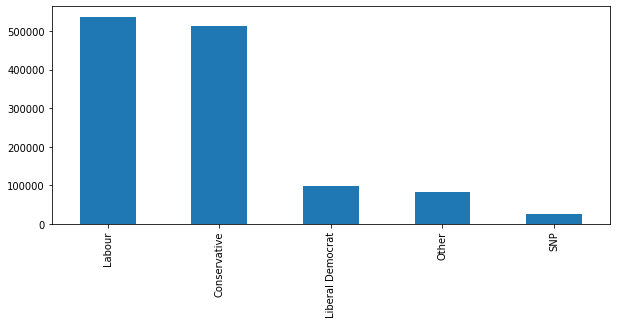

In [33]:
plt.figure(figsize=(10,4))
hansard['party_group'].value_counts().plot(kind='bar');

#### Dealing with imbalanced data 
1. Three classes: Liberal Democrat, SNP and party_group can be aggregated into one class called other

In [0]:
hansard.loc[hansard.party_group == 'SNP', 'party_group'] = 'Other'
hansard.loc[hansard.party_group == 'Liberal Democrat', 'party_group'] = 'Other'

In [35]:
hansard['party_group'].value_counts() / len(hansard)

Labour          0.429253
Conservative    0.409103
Other           0.161644
Name: party_group, dtype: float64

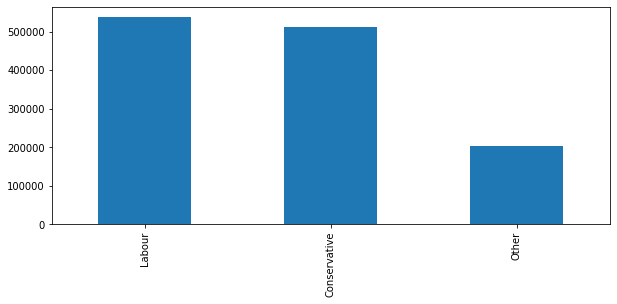

In [36]:
plt.figure(figsize=(10,4))
hansard['party_group'].value_counts().plot(kind='bar');

# Train test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, hansard_test, y_train, hansard_test_y = train_test_split(hansard, hansard['party_group'], test_size=0.1, random_state=42)

In [39]:
print('Party_Group distribution in training set: ')
print(X_train['party_group'].value_counts() / len(hansard))
print('\nParty_Group distribution in test set: ')
print(hansard_test['party_group'].value_counts() / len(hansard))

Party_Group distribution in training set: 
Labour          0.386323
Conservative    0.367986
Other           0.145691
Name: party_group, dtype: float64

Party_Group distribution in test set: 
Labour          0.042930
Conservative    0.041117
Other           0.015953
Name: party_group, dtype: float64


In [0]:
hansard_train, hansard_val, hansard_train_y, hansard_val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [41]:
print('Party_Group distribution in training set: ')
print(X_train['party_group'].value_counts() / len(hansard))
print('\nParty_Group distribution in test set: ')
print(hansard_test['party_group'].value_counts() / len(hansard))

Party_Group distribution in training set: 
Labour          0.386323
Conservative    0.367986
Other           0.145691
Name: party_group, dtype: float64

Party_Group distribution in test set: 
Labour          0.042930
Conservative    0.041117
Other           0.015953
Name: party_group, dtype: float64


In [42]:
#hansard_train
#gansard_ val
#hansard_test
print(hansard_train.isnull().sum())

print(hansard_val.isnull().sum())
print(hansard_test.isnull().sum())

party_group       0
speech_cleaned    0
dtype: int64
party_group       0
speech_cleaned    0
dtype: int64
party_group       0
speech_cleaned    0
dtype: int64


- hansard_train
- hansard_test
- hansard_val

# Tokenize speeches in train set and validation set

In [0]:
speech_list_train = hansard_train['speech_cleaned'].tolist()
speech_list_val = hansard_val['speech_cleaned'].tolist()

In [44]:
%%time
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(hansard_train['speech_cleaned'].tolist())
word_index_train = tokenizer.word_index
dict(list(word_index_train.items())[0:10])

CPU times: user 1min 28s, sys: 121 ms, total: 1min 28s
Wall time: 1min 28s


In [46]:
%%time
tokenizer.fit_on_texts(hansard_val['speech_cleaned'].tolist())
word_index_val = tokenizer.word_index
dict(list(word_index_val.items())[0:10])

CPU times: user 24 s, sys: 94.5 ms, total: 24.1 s
Wall time: 24.1 s


In [47]:
hansard_train['speech_cleaned'].head(3)

383139    "may associate constituency expression regret ...
945784    prime minister tell whether, end parliament, l...
830106    "does minister agree justice best dispensed ne...
Name: speech_cleaned, dtype: object

In [48]:
hansard_val['speech_cleaned'].head(3)

361653     discussions scottish executive encouraging rec...
1235615                                  minister give way?+
1157185    accept must accept referendum decision, proble...
Name: speech_cleaned, dtype: object

In [0]:
%%time
train_sequences = tokenizer.texts_to_sequences(hansard_train['speech_cleaned'])
val_sequences = tokenizer.texts_to_sequences(hansard_val['speech_cleaned'])

In [50]:
type(train_sequences)

list

In [51]:
print(len(train_sequences))
print(len(val_sequences))

901372
225344


In [52]:
# padding train_sequences to 200
train_padded = pad_sequences(train_sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

45
200
11
200
1
200


In [53]:
# padding val_sequences to 200
val_padded = pad_sequences(val_sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)
print(len(val_sequences[0]))
print(len(val_padded[0]))

print(len(val_sequences[1]))
print(len(val_padded[1]))

print(len(val_sequences[10]))
print(len(val_padded[10]))

6
200
3
200
50
200


In [54]:
#Tokenizing the train_labels and val_labels

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(hansard_train_y.tolist())

label_tokenizer.fit_on_texts(hansard_val_y.tolist())

train_label_seq = label_tokenizer.texts_to_sequences(hansard_train_y.tolist())
val_label_seq = label_tokenizer.texts_to_sequences(hansard_val_y.tolist())

print(type(train_label_seq))
print(type(val_label_seq))

<class 'list'>
<class 'list'>


In [55]:
print(type(train_label_seq))
print(type(val_label_seq))
print(len(train_label_seq))
print(len(val_label_seq))

<class 'list'>
<class 'list'>
901372
225344


# Models


### Model_0
We use an embeding layer trianed with our own data. 

Then a bidirectional LSTM. 

A dense layer with activation relu and the output layer gets a softmax activation function. 

In [56]:
# This is the first model we tried
model_0 = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 50 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          250000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 295,654
Trainable params: 295,654
Non-trainable params: 0
_________________________________________________________________


In [62]:
%%time
model_0.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_0.fit(tf.convert_to_tensor(train_padded), tf.convert_to_tensor(train_label_seq), epochs=2, validation_data=(tf.convert_to_tensor(val_padded), tf.convert_to_tensor(val_label_seq)), verbose=2)

Train on 901372 samples, validate on 225344 samples
Epoch 1/2
901372/901372 - 617s - loss: 0.8819 - accuracy: 0.5710 - val_loss: 0.8247 - val_accuracy: 0.6096
Epoch 2/2
901372/901372 - 615s - loss: 0.7981 - accuracy: 0.6280 - val_loss: 0.7855 - val_accuracy: 0.6356


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


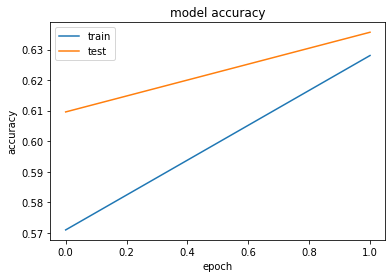

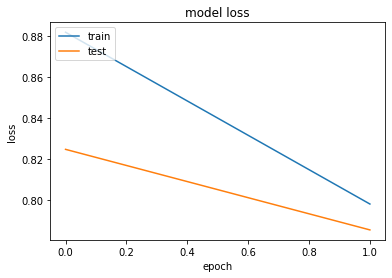

In [63]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see that train accuracy line (blue) has a faster grow than the validation accuracy. Also, in the loss plot, train loss falls faster than accuracy loss. We we train this model with more eopchs, we see that after 5 epoch, validation accuracy won't change but training accuracy keeps growing. This is the issue of overfitting. In the next model, we try to solve this issue. 

### Model_1
Model_0 suffered from overfitting. Here we try to solve this issue. 

We add a Conv1D layer to speed up the computation and also solve the overfitting issue. 

We add a drop out layer after the embedding layer. 

In [58]:
model_1 = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 50 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          16064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [64]:
%%time
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_1.fit(tf.convert_to_tensor(train_padded), tf.convert_to_tensor(train_label_seq), epochs=5, validation_data=(tf.convert_to_tensor(val_padded), tf.convert_to_tensor(val_label_seq)), verbose=2)

Train on 901372 samples, validate on 225344 samples
Epoch 1/5
901372/901372 - 242s - loss: 0.9136 - accuracy: 0.5390 - val_loss: 0.8367 - val_accuracy: 0.6007
Epoch 2/5
901372/901372 - 238s - loss: 0.8258 - accuracy: 0.6073 - val_loss: 0.8061 - val_accuracy: 0.6215
Epoch 3/5
901372/901372 - 234s - loss: 0.7936 - accuracy: 0.6297 - val_loss: 0.7941 - val_accuracy: 0.6298
Epoch 4/5
901372/901372 - 232s - loss: 0.7756 - accuracy: 0.6414 - val_loss: 0.7829 - val_accuracy: 0.6376
Epoch 5/5
901372/901372 - 227s - loss: 0.7638 - accuracy: 0.6482 - val_loss: 0.7776 - val_accuracy: 0.6399
CPU times: user 30min 7s, sys: 3min 37s, total: 33min 45s
Wall time: 19min 33s


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


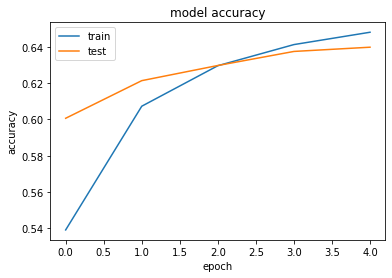

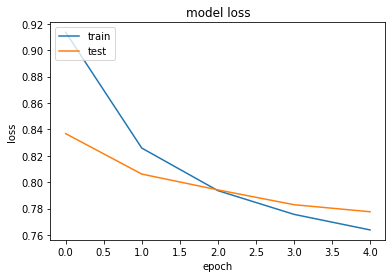

In [65]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

this time we have 5 epochs. The overfitting pattern still exist. 

### Model_2

Now we try another variation of our model. We changed the LSTM layer to a bidirectional one. 

Add one more dense layer and add drop out after embedding, bidirectional and the dense layers (not the classification layer)

In [60]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          250000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          16064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               46000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

In [66]:
%%time
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_2.fit(tf.convert_to_tensor(train_padded), tf.convert_to_tensor(train_label_seq), epochs=5, validation_data=(tf.convert_to_tensor(val_padded), tf.convert_to_tensor(val_label_seq)), verbose=2)

Train on 901372 samples, validate on 225344 samples
Epoch 1/5
901372/901372 - 320s - loss: 0.9064 - accuracy: 0.5498 - val_loss: 0.8420 - val_accuracy: 0.5952
Epoch 2/5
901372/901372 - 318s - loss: 0.8476 - accuracy: 0.5981 - val_loss: 0.8316 - val_accuracy: 0.6055
Epoch 3/5
901372/901372 - 319s - loss: 0.8261 - accuracy: 0.6141 - val_loss: 0.8084 - val_accuracy: 0.6235
Epoch 4/5
901372/901372 - 318s - loss: 0.8111 - accuracy: 0.6250 - val_loss: 0.8007 - val_accuracy: 0.6291
Epoch 5/5
901372/901372 - 317s - loss: 0.8006 - accuracy: 0.6319 - val_loss: 0.7924 - val_accuracy: 0.6336
CPU times: user 40min 19s, sys: 5min 29s, total: 45min 48s
Wall time: 26min 31s


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


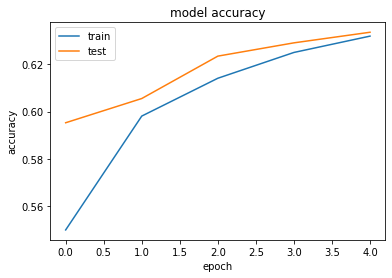

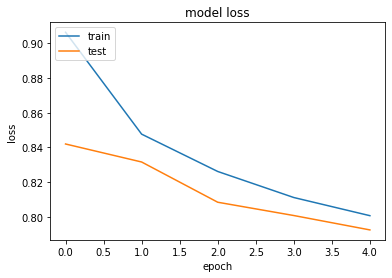

In [67]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We see some fluctuations and unstability in the accuracy and loss graphs. The overfitting patter is still there. Seems like adding more parameter points didn't help the final result. 

## Model_3

In this model we include "weight normalization", "Drop out", "Batch Normalization"

### Prepare the pretrained embedding layer

In [68]:
%%time
from google.colab import files
uploaded = files.upload()

Saving glove.6B.50d.txt to glove.6B.50d.txt
CPU times: user 1min 3s, sys: 3.74 s, total: 1min 6s
Wall time: 42min 36s


In [69]:
%%time
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded
CPU times: user 5.84 s, sys: 61.5 ms, total: 5.9 s
Wall time: 5.88 s


In [0]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, index in word_index_train.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [72]:
len(embedding_matrix)

5000

In [73]:
%%time
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, kernel_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          250000    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          16064     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               46000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)              

In [74]:
model_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_3.fit(tf.convert_to_tensor(train_padded), tf.convert_to_tensor(train_label_seq), epochs=2, validation_data=(tf.convert_to_tensor(val_padded), tf.convert_to_tensor(val_label_seq)), verbose=2)

Train on 901372 samples, validate on 225344 samples
Epoch 1/2
901372/901372 - 369s - loss: 1.0137 - accuracy: 0.4676 - val_loss: 0.9255 - val_accuracy: 0.5390
Epoch 2/2
901372/901372 - 355s - loss: 0.9267 - accuracy: 0.5587 - val_loss: 0.8886 - val_accuracy: 0.5723


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


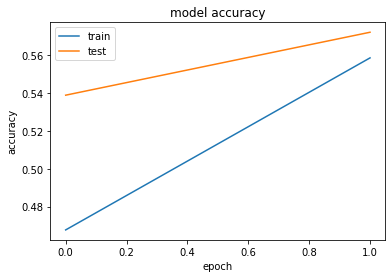

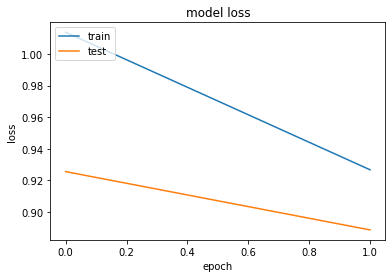

In [75]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Refrences 
- https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
- https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
- https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model
- https://stats.stackexchange.com/questions/122409/why-downsample
- https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
- https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28
- https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610